In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read all words
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# Vocabulary and chars mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# Hyperparameters
block_size = 4
embedding_size = 20
hidden_layer_size = 200
epochs = 200000
minibatch_size = 64
learning_rate = 0.1
lr_decay_factor = 10

In [5]:
# Create database
def create_db(words):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train, y_train = create_db(words[:n1])
X_dev, y_dev = create_db(words[n1:n2])
X_test, y_test = create_db(words[n2:])

In [6]:
len(X_train), len(X_dev), len(X_test)

(182625, 22655, 22866)

In [7]:
# Initialize weights
g = torch.Generator().manual_seed(2147483647)
E = torch.randn((27, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_layer_size), generator=g)
b1 = torch.randn(hidden_layer_size, generator=g)
W2 = torch.randn((hidden_layer_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
lmbda = 0.001
parameters = [E, W1, b1, W2, b2]

In [8]:
sum(p.nelement() for p in parameters)

22167

In [9]:
# Require grad
for p in parameters:
    p.requires_grad = True

In [10]:
# Gradient descent
def train_model(parameters, epochs=epochs, minibatch_size=minibatch_size, block_size=block_size, embedding_size=embedding_size,
                learning_rate=learning_rate, lr_decay_factor=lr_decay_factor):
    lossi = []
    stepi = []
    for i in range(epochs):
        # construct minibatch
        ix = torch.randint(0, X_train.shape[0], (minibatch_size,))

        # forward pass
        emb = E[X_train[ix]]
        h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y_train[ix])

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()

        # update
        for p in parameters:
            lr = learning_rate
            if i > int(0.9*epochs):
                lr /= lr_decay_factor
            p.data += -learning_rate * p.grad
        stepi.append(i)
        lossi.append(loss.log10().item())
    plt.plot(stepi, lossi)
    return parameters

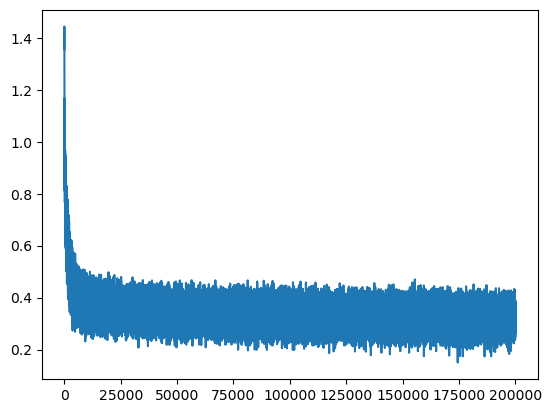

In [11]:
m = train_model(parameters)

In [12]:
# Train loss
emb = E[X_train]
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
print(loss.item())

2.119418144226074


In [13]:
# Dev loss
emb = E[X_dev]
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_dev)
print(loss.item())

2.194654941558838


In [14]:
# Test loss
emb = E[X_test]
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_test)
print(loss.item())

2.194103717803955


In [ ]:
# Sample from model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            br